In [29]:
# ライブラリのインポート

import pyroomacoustics as pra
import matplotlib.pyplot as plt
from IPython.display import display, Audio
import numpy as np
from scipy.io import wavfile

In [30]:
# パラメータ

center = [3,2] # ロボットの初期位置
robot_height = 0.3 # ロボットの高さ
mic_num = 6 # マイクロフォンアレイの数
c = 343.    # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]
snr_db = 5.    # ガウスノイズのSNR
room_dim = np.array([8, 6]) # 部屋の大まかな寸法
# 部屋の寸法
corners = np.array([[0,0], [0,6], [5,6], [5,3], [5.1,3], [5.1,6], [8,6], [8,0]])  # [x,y]
height = 3. # 部屋の高さ

# LiDAR(LDS-01)のスペック
distance_range = (120, 3500) # mm
distance_accuracy = 10 # mm
angular_range = 360 # degree
angular_resolution = 1 # degree

max_field = 10 # 画像化するフィールドの大きさ
spacing = 0.05 # グリッドの間隔(m)

# 音源の位置
sound_locations = np.array([[2., 4., 1.3], 
                            [7., 5., 1.3]])

# 音源のpath
sound_path = './SoundSource/sound_source.wav'

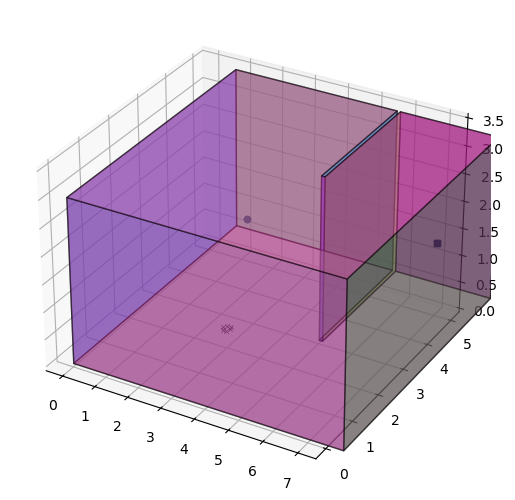

In [38]:
# 初期化処理

num_points = int(max_field / spacing)
# num_points * num_pointsのRGB画像を作成する
image = np.zeros((num_points, num_points, 3), dtype=np.uint8)

# ガウスノイズの設定
sigma2 = 10**(-snr_db / 10) / (4. * np.pi * 2.)**2

# 部屋をつくります
# fsは生成されるインパルス応答のサンプリング周波数です。入力する音源があるならそれに合わせる。
aroom = pra.Room.from_corners(corners.T, fs=fs, materials=None, max_order=3, sigma2_awgn=sigma2, air_absorption=True)
aroom.extrude(height)

# マイクを設置
mic_locs = pra.circular_2D_array(center=center, M=mic_num, phi0=0, radius=0.1)
# z軸座標を追加
mic_locs_z = np.concatenate((mic_locs, np.ones((1, mic_locs.shape[1]))*robot_height), axis=0)
aroom.add_microphone_array(mic_locs_z)

# 音源を作成
_, audio = wavfile.read(sound_path)
#audio = np.random.randn(16000)
aroom.add_source(sound_locations[0], signal=audio)
aroom.add_source(sound_locations[1], signal=audio)
fig, ax = aroom.plot()
ax.set_zlim([0, 3.5])
plt.show()

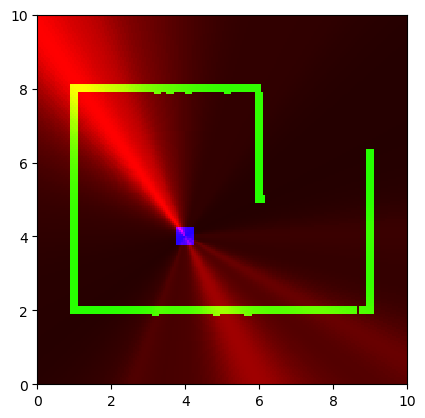

In [39]:
# 繰り返し処理

center = [3,2] # ロボットの現在位置

# 部屋をつくる
aroom = pra.Room.from_corners(corners.T, fs=fs, materials=None, max_order=3, sigma2_awgn=sigma2, air_absorption=True)
aroom.extrude(height)

# マイクを設置
mic_locs = pra.circular_2D_array(center=center, M=mic_num, phi0=0, radius=0.1)
# z軸座標を追加
mic_locs_z = np.concatenate((mic_locs, np.ones((1, mic_locs.shape[1]))*robot_height), axis=0)
aroom.add_microphone_array(mic_locs_z)

# 音源を作成
_, audio = wavfile.read(sound_path)
aroom.add_source(sound_locations[0], signal=audio)
aroom.add_source(sound_locations[1], signal=audio)

# シミュレーションの実行
aroom.simulate()

X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])

# DOAの計算
doa = pra.doa.algorithms['MUSIC'](mic_locs, fs, nfft, c=c, num_src=2, max_four=4)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values
# 標準化
min_val = spatial_resp.min()
max_val = spatial_resp.max()
#spatial_resp = (spatial_resp - min_val) / (max_val - min_val)
spatial_resp = (spatial_resp) / (max_val) # normalize to 0-1

# 音源の方向を描画するgridの作成

# 各グリッドの座標の中心点を計算
x = np.arange(0, max_field, spacing) + spacing / 2
y = np.arange(0, max_field, spacing) + spacing / 2
points = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
center_ = max_field/2 - room_dim/2 + center
# 各点について、マイクロフォンアレイの座標からの角度を計算
angles = np.arctan2(points[:,1] - center_[1], points[:,0] - center_[0])*180/np.pi
# 小数点以下を四捨五入
angles = np.round(angles)
# 0から360度までの範囲にする
angles[angles < 0] += 360
# gridの各点について、anglesの値番目のdataを代入
for i, angle in enumerate(angles):
    image[:,:,0][int(points[i,0]/spacing), int(points[i,1]/spacing)] = np.round(spatial_resp[int(angle)]*255)
# gridをプロット
# plt.imshow(image[0].T, cmap='jet', interpolation='nearest', extent=[0, max_field, 0, max_field], origin='lower')

# lidarのデータを描画するgridの作成

point_list = []
for angle in range(0, 180, angular_resolution):
    theta = np.deg2rad(angle + angular_resolution/2)
    points = [[1e5, 1e5], [-1e5, -1e5]]
    for i in range(len(corners)):
        epsilon = 1e-6
        a, b = center
        p, q = corners[i%len(corners)]
        r, s = corners[(i+1)%len(corners)]
        x = (b - s - a*np.tan(theta) + r*(q - s)/(p - r + epsilon))/((q - s)/(p - r + epsilon) - np.tan(theta))
        y = np.tan(theta)*x + b - a*np.tan(theta)
        if (x - p)*(x - r) <= epsilon and (y - q)*(y - s) <= epsilon: # 線分上にあるか
            # x > center[0]の点からxが最も小さい点を選ぶ
            if x >= center[0]:
                if points[0][0] > x:
                    points[0] = [x, y]
            # x < center[0]の点からxが最も大きい点を選ぶ
            else:
                if points[1][0] < x:
                    points[1] = [x, y]
    point_list.append(points[0])
    point_list.append(points[1])
point_list_np = np.array(point_list) + max_field/2 - room_dim/2 # m
# ポイントをグリッドに描画
size = 2
for point in point_list_np:
    x, y = point
    x = int(x / spacing)
    y = int(y / spacing)
    image[:,:,1][x-size:x+size, y-size:y+size] = 255
# gridをプロット
# plt.imshow(image[1].T, cmap='jet', interpolation='nearest', extent=[0, 10, 0, 10], origin='lower')

# ロボットの位置を描画するgridの作成
x, y = center_
x = int(x / spacing)
y = int(y / spacing)
size = 5
image[:,:,2][x-size:x+size, y-size:y+size] = 255
# gridをプロット
# plt.imshow(image[2].T, cmap='jet', interpolation='nearest', extent=[0, 10, 0, 10], origin='lower')

# 画像を表示
plt.imshow(image.transpose([1,0,2]), interpolation='nearest', extent=[0, max_field, 0, max_field], origin='lower')